# はじめに

本プログラムは**飛行機をQ-learningにより自動で操縦することを目指したプログラム**です。

飛行のモデリングは『航空機力学入門　(加藤寛一郎・大屋昭男・柄沢研治 著　東京大学出版会)』の3章「微小擾乱の運動方程式」をベースに作成しています。

そしてQ-lerningの実装は東京大学松尾研究室の「サマースクール2024 深層強化学習」をベースにしております。

水平旋回を目指して学習させた結果が以下の感じです。


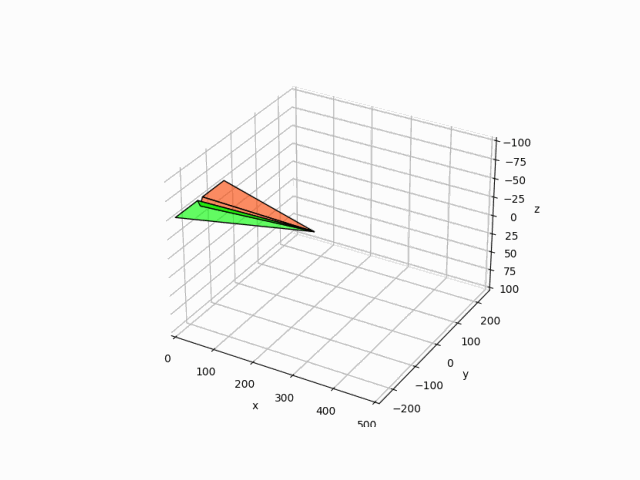

In [9]:
from IPython.display import Image
#Image('./paper_plane.gif', format='png')

また、今回は以下の記事の続きです。

https://qiita.com/yuki_2020/items/95d928a800db970df408

https://colab.research.google.com/drive/1jFq-XIw-yQpS2RginQjdrnzy5B6X8I1I?usp=sharing

# 各関数

基本的に前回と変わっておりませんが、機体の速度ベクトルを計算する部分を関数化しました。

In [2]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import mpl_toolkits.mplot3d.art3d as art3d
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.notebook import tqdm

In [3]:
# --- 回転行列の定義 ---
def rotation_matrix(psi, theta, phi):
  # z軸周り回転
  R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                   [np.sin(psi), np.cos(psi), 0],
                   [0, 0, 1]])
  # y軸周り回転
  R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                   [0, 1, 0],
                   [-np.sin(theta), 0, np.cos(theta)]])
  # x軸周り回転
  R_x = np.array([[1, 0, 0],
                   [0, np.cos(phi), -np.sin(phi)],
                   [0, np.sin(phi), np.cos(phi)]])
  # 全体の回転行列
  R = R_z @ R_y @ R_x
  return R



#全体座標系における速度ベクトルの取得
def get_global_velosity(U0, u, alpha, beta, psi, theta, phi):
    # 機体座標系での速度ベクトル
    u_b = U0 + u
    v_b = u_b * np.sin(beta)
    w_b = u_b * np.tan(alpha)
    vel_b = np.array([u_b, v_b, w_b])

    # 全体座標系での速度ベクトル
    vel_e = rotation_matrix(psi, theta, phi) @ np.atleast_2d(vel_b).T
    vel_e = vel_e.flatten()
    return vel_e




#紙飛行機の描写関数
def plot_paper_airplane(x, y, z, phi, theta, psi, scale, ax):
    """
    3次元座標と角度が与えられたとき、その状態の紙飛行機のような図形をプロットする

    Args:
      x: x座標
      y: y座標
      z: z座標
      psi: ロール角 (ラジアン)
      theta : ピッチ角 (ラジアン)
      phi: ヨー角 (ラジアン)
      機体の大きさをいじりたければscaleを変える

    """

    #三角形を描く
    poly_left_wing = scale * np.array([[2, 0.0, 0],
                                      [-1, 1, 0],
                                      [-1, 0.1, 0]])
    poly_right_wing = poly_left_wing.copy()
    poly_right_wing[:,1] = -1 * poly_right_wing[:,1]

    poly_left_body = scale * np.array([[2, 0.0, 0.0],
                                      [-1, 0.0, +0.1],
                                      [-1, 0.1, 0.0]])
    poly_right_body = poly_left_body.copy()
    poly_right_body[:,1] = -1 * poly_right_body[:,1]



    R = rotation_matrix(psi, theta, phi) # yaw, pitch, roll


    for points in [poly_left_wing, poly_left_body, ]:
        # 紙飛行機の点を回転
        translated_rotated_points = (R @ points.T).T + np.array([x, y, z])
        #描写
        ax.add_collection3d(art3d.Poly3DCollection([translated_rotated_points],facecolors='orangered', linewidths=1, edgecolors='k', alpha=0.6))

    for points in [poly_right_wing, poly_right_body]:
        # 紙飛行機の点を回転
        translated_rotated_points = (R @ points.T).T + np.array([x, y, z])
        #描写
        ax.add_collection3d(art3d.Poly3DCollection([translated_rotated_points],facecolors='lime', linewidths=1, edgecolors='k', alpha=0.6))


# OpenAIのgym形式での飛行モデルの作成

強化学習ではOpenAIが作成したライブラリであるgymと互換性があるように環境をモデル化することで、過去に作られた豊富な強化学習プログラムがそのまま使えるようになります。

そのため、今回は今まで作成したシミュレーターをgym形式に変更するところから始めていきます。

参考：

https://developers.agirobots.com/jp/openai-gym-custom-env/

https://qiita.com/ohtaman/items/edcb3b0a2ff9d48a7def#gym-%E3%81%AB%E7%99%BB%E9%8C%B2%E3%81%99%E3%82%8B

https://kagglenote.com/ml-tips/my-environment-with-gym/

https://developers.agirobots.com/jp/openai-gym-custom-env/

# 飛行モデル

飛行モデルを決める機体パラメータはクラス変数として定義しました。
さらに、飛行をシミュレートする微分方程式はクラス内部で実行できるよう引数に機体速度であるU0を追加しています。
また、`u_long`及び`u_lat`について、actionから入れやすいように`u_inp`を受け取り内部で分割するように変更しました。

## init
initで重要な点としては、ここで時間幅dtを決めていることです。
dtが短ければ細かい入力ができますが、1エピソードの実行時間が長くなります。
逆に大きくしすぎると学習は早くなりますが、かくかくした入力になってしまいます。

また、シミュレーション時間は一律100sにするために、`max_episode_steps`を計算しています。これはもともと互換性を持たせるために`env.spec.max_episode_steps`とアクセスできるようにしたかったのですが、できなかったため`env.max_episode_steps`というようにアクセスするようにしています。


## reset

ここでは単に変数を初期化しているだけです。
作成時のバグとして、ここで`self.done=False`歳忘れていたため、次のステップに移る際に`True`のままなので1ステップでエピソードが終了してしまうという問題がありました。

## step

### シミュレーション
ここでは、行動である`action`を受け取って1ステップだけ微分方程式を解いています。

ここで`action`は入力のベクトルではなく、入力uのどれを選択したかという番号となっています。
そのため、入力uのうちactioonで選択された変数だけ1とし、残りは0とするようなコードにしています。
さらに、プラスかマイナスどちらかわかるように、前半はプラスの入力、後半は間ナスの入力として割り当て、引き算することで`u_inp`に変換しています。

### observation
微分方程式を解いた結果のほか、全体座標系における速度ベクトルも追加して環境`observation`としています。

### reward
報酬を決める部分で学習でとても重要な部分です。
今回は、水平に180°旋回することを目指しています。

そのため、
1. なるべく早く終わってほしいので時間経過で減少
2. 目標である真後ろを向いてほしいのでコサイン類似度に応じて増加
3. 高度を変えずに旋回してほしいので高度変化に応じて減少
としており、上記はステップごとに行われるため、dtに依存することを避けるためにdtを掛け算して同じ時間当たりの報酬の変化を一定にしています。

さらに、終了判定として
1. コサイン類似度が0.95以上　→　報酬を与え終了
2. 飛行時間が100sを超える　→　終了

というようにしました。


### render

今回は今まで作ってきた紙飛行機を描写するプログラムを使い、各フレームの描写をnumpyのarray形式で出力しています。
これによって後から動画を作ることができます。

In [4]:
import gym
class FlightSimulatorEnv(gym.Env):
    metadata = {'render.modes': ['rgb_array']}

    # --- 機体パラメータ ---
    g = 9.81
    # 初期条件
    U0 = 293.8
    W0 = 0
    theta0 = 0.0

    # 縦の有次元安定微係数: ロッキードP2V-7
    Xu = -0.0215
    Zu = -0.227
    Mu = 0

    Xa = 14.7
    Za = -236
    Ma = -3.78
    Madot = -0.28

    Xq = 0
    Zq = -5.76
    Mq = -0.992

    X_deltat = 0.01#0
    Z_deltae = -12.9
    Z_deltat = 0
    M_deltae = -2.48
    M_deltat = 0


    # 横・方向の有次元安定微係数: ロッキードP2V-7
    Yb=-45.4
    Lb=-1.71
    Nb=0.986

    Yp=0.716
    Lp=-0.962
    Np=-0.0632

    Yr=2.66
    Lr=0.271
    Nr=-0.215

    #Y_deltaa=0
    L_deltaa=1.72
    N_deltaa=-0.0436

    Y_deltar=9.17
    L_deltar=0.244
    N_deltar=-0.666




    # --- 縦の運動方程式 ---
    # 行列A, Bの定義
    A_long = np.array([[Xu, Xa, -W0, -g * np.cos(theta0)],
                      [Zu / U0, Za / U0, 1 + Zq / U0, (g / U0) * np.sin(theta0)],
                      [Mu + Madot * (Zu / U0), Ma + Madot * (Za / U0), Mq + Madot * (1 + Zq / U0),
                        (Madot * g / U0) * np.sin(theta0)],
                      [0, 0, 1, 0]])

    B_long = np.array([[0, X_deltat],
                      [Z_deltae / U0, Z_deltat / U0],
                      [M_deltae + Madot * (Z_deltae / U0), M_deltat + Madot * (Z_deltat / U0)],
                      [0, 0]])


    # --- 横・方向の運動方程式 ---
    # 行列A, Bの定義
    A_lat = np.array([[Yb / U0, (W0 + Yp) / U0, (Yr / U0 - 1), g * np.cos(theta0) / U0, 0],
                      [Lb, Lp, Lr, 0, 0],
                      [Nb, Np, Nr, 0, 0],
                      [0, 1, np.tan(theta0), 0, 0],
                      [0, 0, 1 / np.cos(theta0), 0, 0]])

    B_lat = np.array([[0, Y_deltar / U0],
                      [L_deltaa, L_deltar],
                      [N_deltaa, N_deltar],
                      [0, 0],
                      [0, 0]])


    # --- 統合モデル ---
    def aircraft_dynamics(self, t, x, U0, A_long, B_long, A_lat, B_lat, u_inp):

      u_long = u_inp[:2]
      u_lat = u_inp[2:]

      # 縦の運動方程式
      dxdt_long = A_long @ np.atleast_2d(x[:4]).T + B_long @ np.atleast_2d(u_long).T
      dxdt_long = dxdt_long.flatten()

      # 横・方向の運動方程式
      dxdt_lat = A_lat @ np.atleast_2d(x[4:9]).T + B_lat @ np.atleast_2d(u_lat).T
      dxdt_lat = dxdt_lat.flatten()

      # 機体座標系から全体座標系での速度ベクトルへの変換
      vel_e = get_global_velosity(U0=U0, u=x[0], alpha=x[1], beta=x[4], psi=x[8], theta=x[3], phi=x[7])

      # 縦と横・方向の状態量の変化と位置の変化を結合
      dxdt = np.concatenate((dxdt_long, dxdt_lat, vel_e))
      return dxdt







    def __init__(self):
        self.x0 = np.zeros(12)
        self.dt = 1
        self.max_episode_steps = int(100/1)

        self.action_space = gym.spaces.Discrete(8)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(15,), dtype=np.float32)
        self.reward_range = (-np.inf, np.inf)
        self.reset()

    def reset(self):
        self.x = self.x0
        self.t = 0
        self.observation = np.concatenate((self.x, np.array([self.U0, 0, 0])))#速度の変数を追加

        self.done = False
        self.all_soly = self.x0.reshape(len(self.x0),1)

        return self.observation

    def step(self, action):
        start_time = time.time()

        u_action = np.zeros(self.action_space.n)
        u_action[action] = 1

        #u_actionの前半をプラス方向の入力、後半をマイナスの入力として実装
        self.u_inp = u_action[:self.action_space.n//2] - u_action[self.action_space.n//2:]

        # t~t+dtまで微分方程式を解く (RK45メソッドを使用)
        sol = solve_ivp(self.aircraft_dynamics, [self.t, self.t+self.dt], self.x,
            args=(self.U0, self.A_long, self.B_long, self.A_lat, self.B_lat, self.u_inp),
            method='RK45')

        #t~t+dtまでの結果を追加
        self.all_soly = np.append(self.all_soly, sol.y, axis=1)

        #次のt+dtにおける初期条件
        self.x = sol.y[:, -1] #現在の最終状態
        self.t += self.dt

        vel_e = get_global_velosity(U0=self.U0, u=self.x[0], alpha=self.x[1], beta=self.x[4], psi=self.x[8], theta=self.x[3], phi=self.x[7])
        #状態量
        self.observation = np.concatenate((self.x, vel_e)) * 10





        # --- 報酬の設定 ---

        # --- 時間に応じた報酬の設定 ---
        #短時間で達成できるようにしたい
        self.reward = -1 #時間に応じて減額

        #高度を変えないでほしい 1000ftで0.1の減少
        self.reward -= abs(self.x[11])/10**4

        #180°旋回することを目的とする
        target_vecor = np.array([-1, 0, 0])
        #速度ベクトルと目標ベクトルのコサイン類似度で報酬
        vel_e = get_global_velosity(U0=self.U0, u=self.x[0], alpha=self.x[1], beta=self.x[4], psi=self.x[8], theta=self.x[3], phi=self.x[7])
        cosine_similarity = np.dot(target_vecor, vel_e)/(np.sqrt(np.dot(target_vecor, target_vecor))*np.sqrt(np.dot(vel_e, vel_e)))
        self.reward +=  cosine_similarity

        #時間幅に依存しないようにしたい
        self.reward *= self.dt

        #ほぼ目標を向いたら終了
        if cosine_similarity > 0.95:
            self.done = True
            self.reward += 100

        #終了判定
        if self.t >= 100: #100s経過した場合
            self.done = True
            #self.reward -= 100


        #info
        self.info = elapsed_time = time.time() - start_time

        #print(self.t, self.done, self.reward)


        return self.observation, self.reward, self.done, self.info




    def render(self, mode='rgb_array'):

        if mode == 'rgb_array':
            plt.ion()
            fig = plt.figure(dpi=100)
            ax = Axes3D(fig)
            fig.add_axes(ax)
            ax.invert_zaxis()
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            ax.set_xlim(0, 500)
            ax.set_ylim(-250, 250)
            ax.set_zlim(100, -100)

            # 軌跡
            ax.plot(self.all_soly[9], self.all_soly[10], self.all_soly[11])
            ax.set_xlim(min(min(self.all_soly[9]),0), max(max(self.all_soly[9]), 500),)
            ax.set_ylim(min(min(self.all_soly[10]),-250), max(max(self.all_soly[10]), 250),)
            ax.set_zlim(max(max(self.all_soly[11]), 100),min(min(self.all_soly[11]),-100))

            #紙飛行機
            plot_paper_airplane(x=self.x[9],  y=self.x[10], z=self.x[11], phi=self.x[7], theta=self.x[3], psi=self.x[8], scale=100, ax=ax)

            # 描画をキャンバスに保存
            fig.canvas.draw()

            # キャンバスからRGBデータを取得
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

            #メモリ開放
            plt.clf()
            plt.close()

        return image


        def close(self):
            pass

        def seed(self, seed=None):
            pass

# Q-learning

Q-learningでは、状態と行動が離散値でないという欠点があります。
そのため、連続値を離散値に変更しています。

参考
* 東京大学松尾研究室の「サマースクール2024 深層強化学習」
* https://qiita.com/sugulu_Ogawa_ISID/items/bc7c70e6658f204f85f9


In [5]:
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num+1)[1:-1]

# 状態を離散化して対応するインデックスを返す関数（binの上限・下限はcartpole環境固有のものを用いています）
def discretize_state(observation, num_discretize):
    u, alpha, q, theta, beta, p, r, phi, psi, x, y, z, ug, vg, wg = observation
    discretized = [
        np.digitize(u, bins=bins(-20, 20, num_discretize)),
        np.digitize(alpha, bins=bins(-1, 1, num_discretize)),
        np.digitize(q, bins=bins(-2, 2, num_discretize)),
        np.digitize(theta%(2*3.14), bins=bins(0, 2*3.14, num_discretize)),
        np.digitize(beta, bins=bins(-1, 1, num_discretize)),
        np.digitize(p, bins=bins(-2.0, 2.0, num_discretize)),
        np.digitize(r, bins=bins(-2.0, 2.0, num_discretize)),
        np.digitize(phi%(2*3.14), bins=bins(0, 2*3.14, num_discretize)),
        np.digitize(psi%(2*3.14), bins=bins(0, 2*3.14, num_discretize)),
        np.digitize(x, bins=bins(-2*10**5, +2*10**5, num_discretize)),
        np.digitize(y, bins=bins(-2*10**5, +2*10**5, num_discretize)),
        np.digitize(z, bins=bins(-2*10**3, +2*10**3, num_discretize)),
        np.digitize(ug, bins=bins(-500, +500, num_discretize)),
        np.digitize(vg, bins=bins(-500, +500, num_discretize)),
        np.digitize(wg, bins=bins(-500, +500, num_discretize)),
    ]

    return sum([x*(num_discretize**i) for i, x in enumerate(discretized)])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
class QLearning:
    def __init__(self, num_state, num_action, num_discretize, gamma=0.99, alpha=0.5):
        self.num_action = num_action
        self.gamma = gamma  # 割引率
        self.alpha = alpha  # 学習率
        # Qテーブルを作成
        self.qtable = np.zeros((num_discretize**num_state, num_action))

    # Qテーブルを更新
    def update_qtable(self, state, action, reward, next_state):
        self.qtable[state, action] = (1 - self.alpha) *  self.qtable[state, action] + self.alpha* (reward + self.gamma * self.qtable[next_state].max())

    # Q値が最大の行動を選択
    def get_greedy_action(self, state):
        action = np.argmax(self.qtable[state])
        return action

    # ε-greedyに行動を選択
    def get_action(self, state, episode):
        epsilon = 0.7 * (1/(episode+1))  # ここでは0.5から減衰していくようなεを設定
        if epsilon <= np.random.uniform(0,1):
            action = self.get_greedy_action(state)
        else:
            action = np.random.choice(self.num_action)
        return action

  0%|          | 0/2000 [00:00<?, ?it/s]

Episode 0 finished | Episode reward -235.315730
Episode 50 finished | Episode reward 92.802359
Episode 100 finished | Episode reward 80.472927
Episode 150 finished | Episode reward 81.100673
Episode 200 finished | Episode reward 80.086050
Episode 250 finished | Episode reward 82.027165
Episode 300 finished | Episode reward 83.651286
Episode 350 finished | Episode reward 84.608589
Episode 400 finished | Episode reward 27.232427
Episode 450 finished | Episode reward -117.602576
Episode 500 finished | Episode reward 87.667867
Episode 550 finished | Episode reward 81.773408
Episode 600 finished | Episode reward -158.260260
Episode 650 finished | Episode reward 69.297900
Episode 700 finished | Episode reward 80.676207
Episode 750 finished | Episode reward 80.841798
Episode 800 finished | Episode reward 75.271675
Episode 850 finished | Episode reward 82.157742
Episode 900 finished | Episode reward 89.075359
Episode 950 finished | Episode reward 89.075359
Episode 1000 finished | Episode rewar

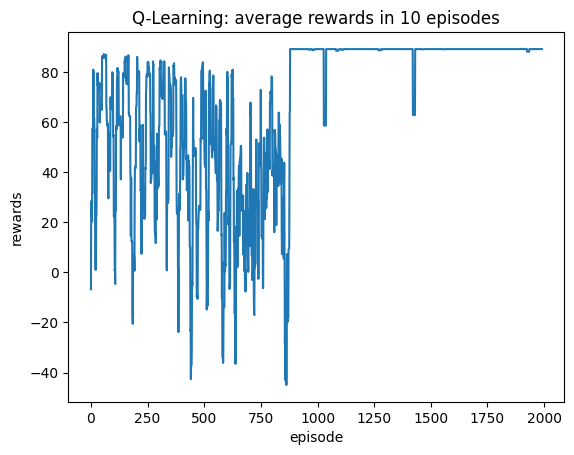

In [7]:
# 各種設定
num_episode =2000#1200  # 学習エピソード数
num_discretize = 5  # 状態空間の分割数
#penalty = 1000#10  # 途中でエピソードが終了したときのペナルティ

# ログ
episode_rewards = []
num_average_epidodes = 10

env = FlightSimulatorEnv()
max_steps =  env.max_episode_steps #env.spec.max_episode_steps  # エピソードの最大ステップ数

agent = QLearning(env.observation_space.shape[0], env.action_space.n, num_discretize)


for episode in tqdm(range(num_episode)):
    observation = env.reset()  # envからは4次元の連続値の観測が返ってくる
    state = discretize_state(observation, num_discretize)  # 観測の離散化（状態のインデックスを取得）
    episode_reward = 0
    for t in range(max_steps):
        action = agent.get_action(state, episode)  #  行動を選択
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        #print(reward, episode_reward)
        next_state = discretize_state(observation, num_discretize)
        agent.update_qtable(state, action, reward, next_state)  # Q値の表を更新
        state = next_state
        if done:
            break
    episode_rewards.append(episode_reward)
    if episode % 50 == 0:
        tqdm.write("Episode %d finished | Episode reward %f" % (episode, episode_reward))

# 累積報酬の移動平均を表示
moving_average = np.convolve(episode_rewards, np.ones(num_average_epidodes)/num_average_epidodes, mode='valid')
plt.plot(np.arange(len(moving_average)),moving_average)
plt.title('Q-Learning: average rewards in %d episodes' % num_average_epidodes)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

env.close()

# 実行結果

Q-learningによって学習された水平旋回を目指した飛行結果が以下になります。

正直後ろは向いてくれたものの高度はかなり落ちてしまいました。

報酬の与え方が悪いのか、それともQ-learingの限界なのかはわかりません。
報酬の与え方をいろいろ試しては見たものの、これが限界でした。

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


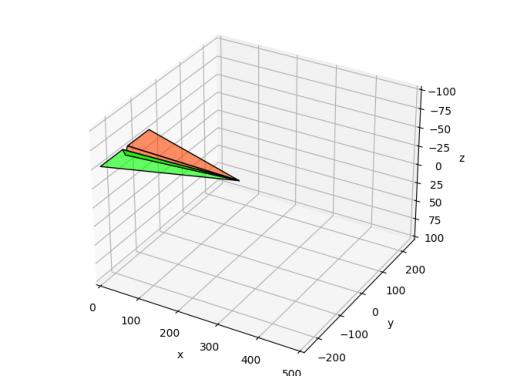

In [8]:
# 最終的に得られた方策のテスト（可視化）
env = FlightSimulatorEnv()
frames = []
for episode in range(1):
    observation = env.reset()
    state = discretize_state(observation, num_discretize)
    frames.append(env.render(mode='rgb_array'))
    done = False
    while not done:
        action = agent.get_greedy_action(state)
        next_observation, reward, done, _ = env.step(action)
        #print(reward)
        frames.append(env.render(mode='rgb_array'))
        state = discretize_state(next_observation, num_discretize)
env.close()

plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=int(2000/len(frames)))
anim.save("paper_plane.gif", writer="imagemagick")
HTML(anim.to_jshtml())